# Week 2

In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
from pandas_datareader import data 
from datetime import datetime
from scipy.optimize import minimize

In [463]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [464]:
import edhec_risk_kit as erk

In [465]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

## Modern portfolio theory (MPT)

The **Modern portfolio theory (MPT)** is a mathematical framework **for assembling a portfolio of assets such that the expected return is maximized for a given level of volatility**. It is a formalization of **diversification in investing**, i.e., the idea that owning different kinds of financial assets is less risky than owning only one type. 

### Efficient Frontiers 

In the MPT, The **efficient frontier** is an a curve which occupies the *efficient* part of the **volatility-return** plane. 
Formally, it is the set of portfolios which satisfy the condition that no other portfolio exists with a higher expected 
return but with the same standard deviation of return. 

The efficient frontier was first formulated by **Harry Markowitz** (1952).

### How it works
We have to construct a portfolio of several assets and **we want to find the optimal percentage of investments to be allocated in these assets** so that the overall (expected) return of such a portfolio is maximixed for a given level of volatility. 

Hence, suppose that **we have $k > 1$ assets**, and we decide to invest all of our capital in these assets. 

Let $\mathbf{w}:=(w_1,\dots,w_K)^T$, with $w_i\in (0,1)$ for all $i=1,\dots,K$, 
be the percentages of investment our portfolio, i.e, $w_i$ is the proportion of investiment in asset $i$. 
There holds $\sum_{i=1}^K w_i = 1$. 

Let $R_i$ and $R_p$ be the return of asset $i$ and the total return of the portfolio, respectively. 
Likewise, let $\sigma_i$ and $\sigma_p$ be the volatility of asset $i$ and the volatility of the portfolio, respectively. 


#### Return of a portfolio
The **total return of the porfolio** is going to be a simple weigthed sum of the (total) returns of single assets, i.e.,
$$
R_p = \sum_{i=1}^K w_i R_i = \mathbf{w}^T \mathbf{R},
$$
where $\mathbf{R} := (R_1,\dots,R_K)^T$.


#### Volatility of a portfolio
The **volatility of the porfolio** is computed as the (square root of the) variance of the weigthed sum of the returns of single assets. 

Let us make and axample with only two assets. We have $w_1$ and $w_2$ and two assets whose returns are $R_1$ and $R_2$. We have:
$$
\sigma_p^2 =   \text{Var}(w_1 R_1 + w_2 R_2) = 
w_1^2 \text{Var}(R_1) + w_2^2\text{Var}(R_2) + 2w_1 w_2\text{cov}(R_1,R_2) =
w_1^2 \sigma_1^2 + w_2^2\sigma_2^2 + 2w_1 w_2\text{cov}(R_1,R_2), 
$$
where 
$$
\text{cov}(R_1,R_2) := \mathbb{E}[(R_i-\mu_i)(R_j - \mu_j)], 
$$
is the **covariance** between asset $i$ and $j$ and where $\mu_i$ and $\mu_j$ denote 
the mean returns of assets $i$ and $j$, respectively. In particular, if we let 
$$
\rho_{ij} := \frac{\text{cov}(R_i,R_j)}{\sigma_i \sigma_j} = \frac{\text{cov}(i,j)}{\sigma_i \sigma_j}, 
$$
denote the **correlation coefficient** between assets $i$ and asset $j$, then the volatilityt of a $2$ assets portfolio becomes:
$$
\sigma_p = 
\sqrt{ w_i^2 \sigma_1^2 + w_2^2 \sigma_2^2 + 2w_1 w_2 \sigma_1 \sigma_2 \rho_{ij} }. 
$$


Now, in case of $K$ assets, we can express the volatility as follows. 
Let $\Sigma$ be the **covariance matrix**, that is, a symmetric square $K\times K$ matrix, $\Sigma = [\sigma_{ij}]$, 
where each element $\sigma_{ij} := \sigma_i \sigma_j \rho_{ij}$ ($i,j=1,\dots,K$) denote the **covariance** between assets $i$ and asset $j$, 
where $\sigma_i$, $\sigma_j$, and $\rho_{ij}$ denote the volatility and the correlation coefficient of assets $i$ and $j$, respectively. 
If $i=j$, $\sigma_{ii}=\sigma_i^2$ is simply the variance of asset $i$ (**diagonal entries are simply the variances**).

The resulting volatility is then given by:
$$
\sigma_p = \sqrt{ \mathbf{w}^T \Sigma \mathbf{w} }
$$


### Efficient frontiers of 2-assets portfoliso 
In the following we do a very artificial example in order to see the curve that is drawn by different portfolios which 
are constructed with only $2$ assets with different correalation $\rho_{12}$. 
First of all, we assume to generate $500$ daily returns of $2$ assets:

In [172]:
nret             = 500
periods_per_year = 252
risk_free_rate   = 0.0

Then, we set up a value for the means and the volatility of our two artifical assets:

In [173]:
mean_1 = 0.001019
mean_2 = 0.001249
vol_1  = 0.016317
vol_2  = 0.019129

and we set up the $6$ correlations of the two assets, and for every fixed correlation, 
we will generate $20$ portfolios by allocating $20$ pairs of weights:

In [174]:
# Correlation goes from 1 (completely correlated) to -1 (conversely correlated)
rhos  = np.linspace(1,-1,num=6) 
ncorr = len(rhos)

# Pairs of weights to be used to construct the portfolios for any given correlation
nweig = 20
w1 = np.linspace(0,1,num=nweig)
w2 = 1 - np.linspace(0,1,num=nweig)
ww = pd.DataFrame( [w1, w2] ).T  

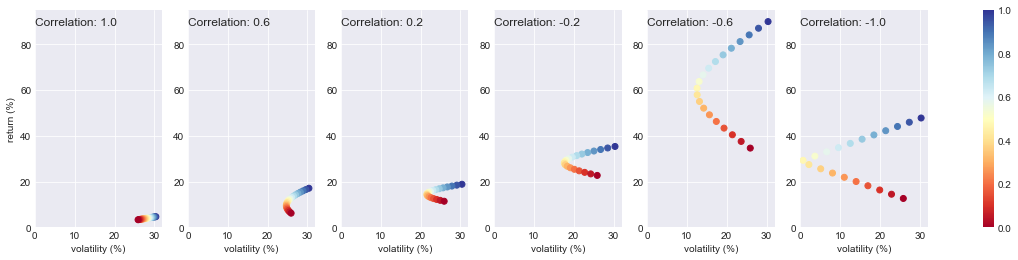

In [175]:
# Set seed
np.random.seed(1)

# Open the figure
fig, ax = plt.subplots(1,6, figsize=(20,4))    
ax = ax.flatten()

for k_rho, rho in enumerate(rhos):
    # Allocate an empty portfolio 
    portfolio = pd.DataFrame(columns=["return","volatility","sharpe ratio"])

    # Generate the assets' returns with the given correlation rho
    cov_ij     = rho * vol_1 * vol_2
    cov_rets   = pd.DataFrame( [[vol_1**2, cov_ij], [cov_ij, vol_2**2]] )
    daily_rets = pd.DataFrame( np.random.multivariate_normal((mean_1,mean_2), cov_rets.values, nret) )
    
    for i in range(ww.shape[0]):
        # Now, construct the portfolio of two asset with correlation rho and weights ww.loc[i]
        weights = ww.loc[i] 
        # here, weights is a column vector (pd.Series)

        # annualized portfolio returns
        ann_rets      = erk.annualize_rets(daily_rets, periods_per_year)
        portfolio_ret = erk.portfolio_return(weights, ann_rets)        

        # annualized portfolio volatility
        portfolio_vol = erk.portfolio_volatility(weights, cov_rets)
        portfolio_vol = erk.annualize_vol(portfolio_vol, periods_per_year)

        # annualized portfolio sharpe ratio
        portfolio_spr = erk.sharpe_ratio(portfolio_ret, risk_free_rate, periods_per_year, v=portfolio_vol)

        # dataframe containing the return, volatility, and the sharpe ratio of the portfolio constructed   
        portfolio = portfolio.append( {"return":portfolio_ret, "volatility": portfolio_vol, "sharpe ratio":portfolio_spr}, ignore_index=True)

    # plot create scatter plot coloured by Sharpe Ratio
    im = ax[k_rho].scatter(portfolio["volatility"]*100, portfolio["return"]*100, c=w2, cmap='RdYlBu') 
    ax[k_rho].grid()
    ax[k_rho].set_title("Correlation: {}".format(np.round(rho,2)), y=0.9, loc='left')
    ax[k_rho].set_xlabel("volatility (%)")
    if k_rho==0: ax[k_rho].set_ylabel("return (%)") 
    ax[k_rho].set_xlim([0,32])
    ax[k_rho].set_ylim([0,95])
    
fig.colorbar(im, ax=ax.ravel().tolist())
plt.show()

For any given correlation, each point represents the pair (return, volatility) of a portfolio constructed with some percentage allocation. 
This can be seen in the colorbar: **red corresponds to $\mathbf{w} = (1,0)$**, i.e., allocation of money only to the first asset, whereas 
**blue corresponds to $\mathbf{w} = (0,1)$**, i.e., allocation of money only ot the second asset.  

We can see that **the lower the correlation between the assets, the better the trade-off between return and volatility**: in this example, 
when $\rho=-1$, we could in principle construct a portfolio which guarantee about $30\%$ of return with almost no volatility.

### Example from the real world: US stocks
Now we will get the timeseries of some US economy stocks and see how to construct a portfolio in an efficient way.

In [473]:
tickers  = ['AMZN','KO','TSLA','MSFT']
n_assets = len(tickers) 

stocks = pd.DataFrame()
for stock_name in tickers:
    # daily data
    stocks[stock_name] = data.DataReader(stock_name, data_source="yahoo", start=datetime(2010,1,1))["Adj Close"]    

In [474]:
stocks.tail()

,AMZN,KO,TSLA,MSFT
Date,,,,
2019-10-10,1720.260010,53.660000,244.740005,139.100006
2019-10-11,1731.920044,53.299999,247.889999,139.679993
2019-10-14,1736.430054,53.299999,256.959991,139.550003
2019-10-15,1767.380005,53.509998,257.890015,141.570007
2019-10-16,1777.545776,53.340000,259.890015,140.005005


In [475]:
# compute the daily returns 
daily_rets = erk.compute_returns(stocks)
daily_rets.tail()

,AMZN,KO,TSLA,MSFT
Date,,,,
2019-10-10,-0.001005,-0.003158,0.000859,0.006221
2019-10-11,0.006778,-0.006709,0.012871,0.004170
2019-10-14,0.002604,0.000000,0.036589,-0.000931
2019-10-15,0.017824,0.003940,0.003619,0.014475
2019-10-16,0.005752,-0.003177,0.007755,-0.011055


In [476]:
# compute the mean daily returns and the covariance of daily returns of the two assets
mean_rets = daily_rets.mean()
std_rets  = daily_rets.std()
cov_rets  = daily_rets.cov()
cov_rets

,AMZN,KO,TSLA,MSFT
AMZN,0.000387,0.000047,0.000182,0.000139
KO,0.000047,0.000087,0.000052,0.000050
TSLA,0.000182,0.000052,0.001050,0.000119
MSFT,0.000139,0.000050,0.000119,0.000208


Now we simulate $4000$ portfolios with weights allocated to the stocks above:

In [477]:
periods_per_year = 252
num_portfolios   = 4000
portfolios       = pd.DataFrame(columns=["return","volatility","sharpe ratio","w1","w2","w3","w4"])
risk_free_rate   = 0

In [478]:
for i in range(num_portfolios):
    # select random weights
    weights = np.random.random(n_assets)
    # and rescale them to sum to 1
    weights /= np.sum(weights)
    
    # annualized portfolio returns
    ann_rets      = erk.annualize_rets(daily_rets, periods_per_year)
    portfolio_ret = erk.portfolio_return(weights, ann_rets)        

    # annualized portfolio volatility
    portfolio_vol = erk.portfolio_volatility(weights, cov_rets)
    portfolio_vol = erk.annualize_vol(portfolio_vol, periods_per_year)

    # annualized portfolio sharpe ratio
    portfolio_spr = erk.sharpe_ratio(portfolio_ret, risk_free_rate, periods_per_year, v=portfolio_vol)
    
    # create dataframe   
    portfolios = portfolios.append( {"return":portfolio_ret, 
                                     "volatility":portfolio_vol, 
                                     "sharpe ratio":portfolio_spr, 
                                     "w1": weights[0], "w2": weights[1], "w3": weights[2], "w4": weights[3]}, 
                                     ignore_index=True)

Now we create a scatter plot coloured by sharpe ratios of the portfolios generated above and we also plot the efficient frontier 

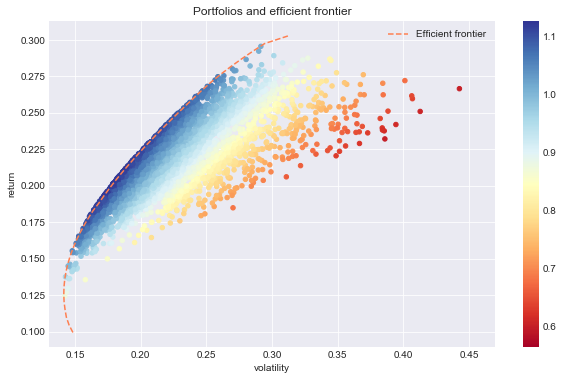

In [544]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 

im = ax.scatter(portfolios["volatility"], portfolios["return"], c=portfolios["sharpe ratio"], s=20, edgecolor=None, cmap='RdYlBu')
ax.set_xlabel("volatility")
ax.set_ylabel("return")
ax.grid()

# Draw the efficient frontier
df = erk.effront_n_assets(40, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")

ax.set_xlim([0.13,0.47])

ax.set_title("Portfolios and efficient frontier")
fig.colorbar(im, ax=ax)
plt.show()

We can see, for example, that if the investor is targeting **a return of $20\%$**, this can be achieved by holding 
a portfolio **with volatility of about $18\%$**, although there are many other portfolios that 
can guarantee the same return but with much higher volatilities such as $28\%$. 
It is clear that one should carefully choose the weights of the portfolio. 

We can see, in particular, that there are two *important* portfolios:

1. the **portfolio with the lowest volatility**, i.e., the minimum variance portfolio
2. the **portfolio with the highest sharpe ratio**.

From the code above we can easily locate these two portfolios in our dataframe by looking at the lowest volatility and highest sharpe ratio 
and and recover the corresponding weights that have been stored.

In [545]:
# find the portfolio with lowest volatility 
low_vol_portfolio = portfolios.iloc[ portfolios['volatility'].idxmin() ]

# find the portfolio with highest sharpe ratio
high_sharpe_portfolio = portfolios.iloc[ portfolios['sharpe ratio'].idxmax() ]

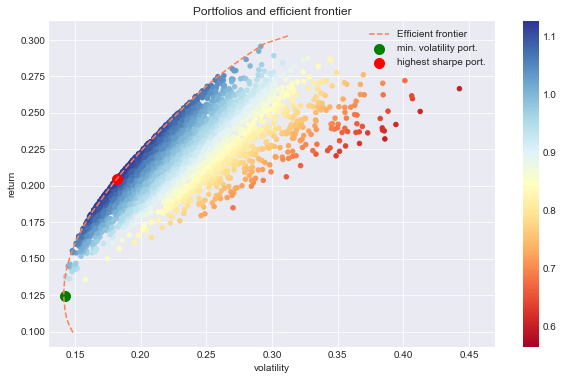

In [547]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 

im = ax.scatter(portfolios["volatility"], portfolios["return"], c=portfolios["sharpe ratio"], s=20, edgecolor=None, label=None, cmap='RdYlBu')
ax.set_xlabel("volatility")
ax.set_ylabel("return")
ax.grid()

# Draw the efficient frontier
#df = erk.effront_n_assets(40, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")

ax.scatter(low_vol_portfolio[1],     low_vol_portfolio[0],     color='g', s=100, label="min. volatility port.")
ax.scatter(high_sharpe_portfolio[1], high_sharpe_portfolio[0], color='r', s=100, label="highest sharpe port.")

ax.set_xlim([0.13,0.47])
ax.legend()

ax.set_title("Portfolios and efficient frontier")
fig.colorbar(im, ax=ax)
plt.show()

In [405]:
ww = minimize_volatility(0.151616, erk.annualize_rets(daily_rets, periods_per_year), cov_rets)
vv = erk.annualize_vol( erk.portfolio_volatility(ww, cov_rets), periods_per_year) 
rr = erk.portfolio_return(ww, erk.annualize_rets(daily_rets, periods_per_year))
print(ww)
print(vv*100)
print(rr*100)

[0.14210245 0.64130619 0.03107898 0.18551238]
14.62870641820395
15.161599999201133


### Finding the optimal portfolios

We can find an optimal portfolio on the efficient frontier by solving a minimization problem through the scipy **optimize** method. 

In particular, note that scipy offers a **minimize** method, but no a **maximize** a method, and we may then conlcude that we are not able to find the portfolio with maximum sharpe ratio in this case. However, **the maximisation of the sharpe ratio is analogous to the minimisation of the negative sharpe ratio**, i.e., the minus sharpe ratio.

In the following, our problem is to **find the portfolio on the efficient frontier which has the minimum volatility for a given level of return**. The minimization problem is:
$$
\text{minimize} \;\; \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w}
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{R} = R_0 \\
\mathbf{w}^T \mathbf{1} = 1 \\
0 \leq \mathbf{w} \leq 1
\end{cases}
$$
Let us consider the following data set of industry return:

In [183]:
ind = erk.get_ind_returns()
ind.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07-01,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08-01,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09-01,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10-01,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11-01,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


Let us just plot the VaRs of the industry indices and their sharpe ratio.

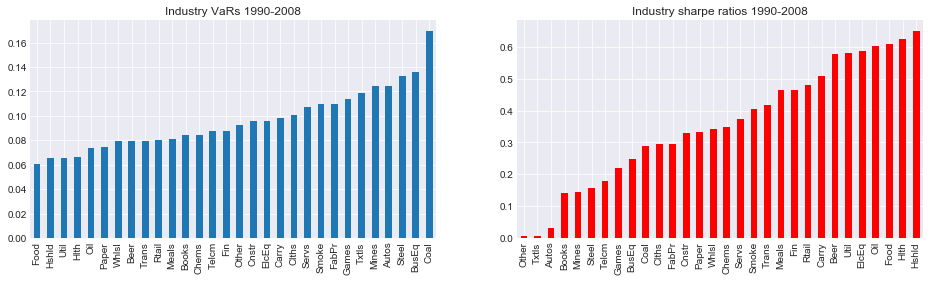

In [184]:
fig, ax = plt.subplots(figsize=(20,4), nrows=1, ncols=2)
erk.var_gaussian(ind["1990":"2008"], cf=True).sort_values().plot.bar(grid=True, figsize=(16,4), ax=ax[0], title="Industry VaRs 1990-2008")
erk.sharpe_ratio(ind["1990":"2008"], 0.0, 12).sort_values().plot.bar(grid=True, figsize=(16,4), ax=ax[1], title="Industry sharpe ratios 1990-2008", color="r")
plt.show()

In [185]:
covmat = ind["1996":"2000"][["Food","Beer","Smoke"]].cov()
covmat

,Food,Beer,Smoke
Food,0.002609,0.002379,0.002061
Beer,0.002379,0.005264,0.001359
Smoke,0.002061,0.001359,0.008349


In [345]:
target_return = 0.15
ind = erk.get_ind_returns()["1996":"2000"]

industries = ["Games","Fin"] #,"Beer"]
monthly_rets = ind[industries]
monthly_rets.tail()

,Games,Fin
2000-08-01,0.0571,0.1020
2000-09-01,-0.0827,0.0229
2000-10-01,-0.0498,-0.0032
2000-11-01,-0.1427,-0.0528
2000-12-01,0.0447,0.1011


In [346]:
covmatrix = monthly_rets.cov()
covmatrix

,Games,Fin
Games,0.003773,0.002416
Fin,0.002416,0.003982


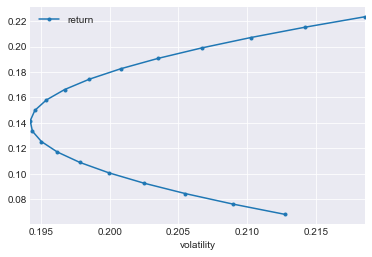

In [348]:
df, fig = erk.effront_two_assets(20, monthly_rets, covmatrix, 12)

In [349]:
df

,volatility,return,sharpe ratio
0,0.218584,0.223371,1.021903
1,0.214239,0.215205,1.004509
2,0.210267,0.207039,0.984648
3,0.206689,0.198873,0.962184
4,0.203525,0.190706,0.937015
5,0.200796,0.182540,0.909080
6,0.198520,0.174374,0.878369
7,0.196711,0.166207,0.844930
8,0.195384,0.158041,0.808874
9,0.194548,0.149875,0.770375


In [378]:
target_return = 0.15
ind = erk.get_ind_returns()["1996":"2000"]

industries = ["Smoke","Fin","Games","Coal"]
monthly_rets = ind[industries]
monthly_rets.tail()

,Smoke,Fin,Games,Coal
2000-08-01,0.1903,0.1020,0.0571,0.1776
2000-09-01,0.0087,0.0229,-0.0827,-0.1372
2000-10-01,0.2280,-0.0032,-0.0498,0.0716
2000-11-01,0.0407,-0.0528,-0.1427,0.0924
2000-12-01,0.1696,0.1011,0.0447,0.4404


In [379]:
covmatrix = monthly_rets.cov()
covmatrix

,Smoke,Fin,Games,Coal
Smoke,0.008349,0.001312,0.000379,-0.000733
Fin,0.001312,0.003982,0.002416,0.002946
Games,0.000379,0.002416,0.003773,0.001888
Coal,-0.000733,0.002946,0.001888,0.018641


In [380]:
#erk.optimal_weights(20, monthly_rets, covmatrix, 12)

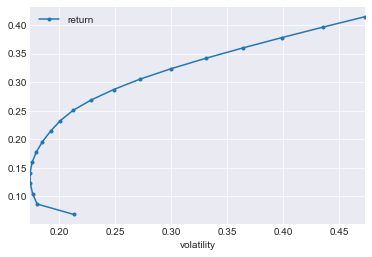

In [381]:
df, fig = erk.effront_n_assets(20, monthly_rets, covmatrix, 12)


In [231]:
weights_015 = erk.minimize_volatility(target_return, ann_rets, covmatrix)
weights_015

array([0.47287631, 0.52712369])

In [232]:
ann_vol = erk.annualize_vol( erk.portfolio_volatility(weights_015, covmatrix), 12 )
ann_vol

0.19455665790383508

In [276]:
a = [1,2,3,4,5]
np.std(a)

1.4142135623730951

In [ ]:
np